# 1. Setup Mario

In [8]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [20]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [22]:
done = True
# Loop through each frame in the game
for frame in range(100000):
    if done:
        # Start the game
        env.reset()
    # Take random actions
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

2024-01-13 12:49:43.747 Python[98177:6534101] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yg/hjwnxjxn51n5m36kvf822s940000gp/T/org.python.python.savedState


In [ ]:
env.close()

# 2. Preprocess Environment

In [9]:
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [10]:
# Create Base Environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplify Controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside dummy environment
env = DummyVecEnv([lambda: env])
# Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [14]:
state = env.reset()

In [15]:
state.shape

(1, 240, 256, 4)

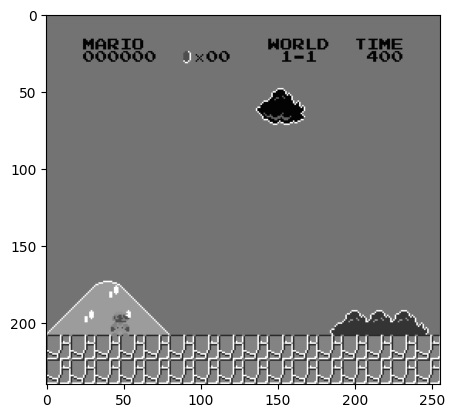

In [17]:
plt.imshow(state[0])

# 3. Train RL Model

In [11]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [13]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [14]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [15]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [16]:
model.learn(total_timesteps=1000000, callback=callback)

2024-01-13 13:31:50.647893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Logging to ./logs/PPO_1
----------------------------
| time/              |     |
|    fps             | 14  |
|    iterations      | 1   |
|    time_elapsed    | 35  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 13            |
|    iterations           | 2             |
|    time_elapsed         | 78            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 4.8060785e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.000474      |
|    learning_rate        | 1e-06         |
|    loss                 | 196           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000631     |
|    value_loss           | 476           |
-------------------------

KeyboardInterrupt: 

# 4. Test it Out

In [17]:
model = PPO.load('./train/best_model_20000')

In [18]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

2024-01-13 14:03:47.292 Python[2058:6552761] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yg/hjwnxjxn51n5m36kvf822s940000gp/T/org.python.python.savedState
